In [1]:
# Install scQuint
# In Google Colab, it might ask you to restart the runtime after installation
!pip install -U git+https://github.com/songlab-cal/scquint.git

  Cloning https://github.com/songlab-cal/scquint.git to /tmp/pip-req-build-ccd52ujr
  Running command git clone --filter=blob:none --quiet https://github.com/songlab-cal/scquint.git /tmp/pip-req-build-ccd52ujr
  Resolved https://github.com/songlab-cal/scquint.git to commit abc53b8945f844eb239648d0ac27dfb684579351
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.5/732.5 kB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.2/377.2 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... do

In [2]:
%%capture
# Download processed intron count data
!wget https://figshare.com/ndownloader/files/27694095 -O adata_spl.h5ad

In [3]:
%%capture
# Download gene annotation
!wget --no-check-certificate https://ftp.ensembl.org/pub/release-102/gtf/mus_musculus/Mus_musculus.GRCm38.102.chr.gtf.gz

In [4]:
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from umap import UMAP

from scquint.data import add_gene_annotation, group_introns, filter_min_cells_per_feature, filter_min_cells_per_intron_group, calculate_PSI
from scquint.differential_splicing import run_differential_splicing, run_differential_splicing_for_each_group, find_marker_introns, mask_PSI
from scquint.dimensionality_reduction.pca import run_pca

In [5]:
# Load preprocessed intron counts
adata = anndata.read_h5ad("adata_spl.h5ad")

# These steps only needed because this data was prepared with older code
adata.var = adata.var[["chromosome", "start", "end", "strand", "annotated"]]
adata.var.end -= 1  # to match the coordinates from this gene annotation
adata.var.index = adata.var.chromosome.astype(str) + ":" + adata.var.start.astype(str) + "-" + adata.var.end.astype(str)
adata = add_gene_annotation(adata, "Mus_musculus.GRCm38.102.chr.gtf.gz")
adata = group_introns(adata, by="three_prime")

adata

/usr/local/lib/python3.10/dist-packages/scquint/data.py:44: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gtf = pd.read_csv(


Filtering to introns associated to 1 and only 1 gene.


/usr/local/lib/python3.10/dist-packages/scquint/data.py:129: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["gene_id"] = adata.var.gene_id_list


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/usr/local/lib/python3.10/dist-packages/pandas/core/generic.py:5931: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


AnnData object with n_obs × n_vars = 6220 × 39329
    obs: 'ar_id', 'exp_component_vendor_name', 'batch', 'batch_vendor_name', 'tube', 'tube_internal_name', 'tube_contents_nm', 'tube_contents_nm_from_vendor', 'tube_avg_size_bp', 'tube_input_fmol', 'r1_index', 'r2_index', 'index_sequence_pair', 'organism', 'facs_container', 'sample_name', 'patched_cell_container', 'cell_name', 'cell_id', 'sample_quantity_count', 'sample_quantity_pg', 'external_donor_name', 'gender', 'control', 'cell_prep_type', 'full_genotype', 'facs_population_plan', 'cre_line', 'reporter', 'injection_roi', 'injection_materials', 'roi', 'patchseq_roi', 'medical_conditions', 'slice_min_pos', 'slice_max_pos', 'rna_amplification_set', 'rna_amplification', 'amp_date', 'pcr_cycles', 'percent_cdna_longer_than_400bp', 'rna_amplification_pass_fail', 'amplified_quantity_ng', 'library_prep_set', 'library_prep', 'lib_date', 'library_input_ng', 'avg_size_bp', 'quantification2_ng', 'quantification_fmol', 'quantification2_nm', 'libr

In [6]:
# Metadata associated to each cell
adata.obs

,ar_id,exp_component_vendor_name,batch,batch_vendor_name,tube,tube_internal_name,tube_contents_nm,tube_contents_nm_from_vendor,tube_avg_size_bp,tube_input_fmol,...,percent_reads_aligned_to_ncrna,percent_reads_aligned_to_introns,percent_reads_aligned_to_intergenic,percent_reads_aligned_unique,cluster_membership,cluster_label,subclass_label,class_label,cluster_color,size
SM-DAIFT_S23_E1-50,602228936,SM-DAIFT-S23,R8S4-170622,RSC-099,SM-DAIFT,R8S4-17062204,7.488752,4.99,420,12,...,15.031277,11.336355,3.371757,84.180973,48,L6 CT Grp_1,L6_CT,Glutamatergic,#197A6E,781
SM-D9E6R_S14_E1-50,593474858,SM-D9E6R-S14,R8S4-170525,RSC-091,SM-D9E6R,R8S4-17052508,7.123295,5.31,399,12,...,15.284132,6.561394,2.902124,81.798517,25,Pvalb Reln,Pvalb,GABAergic,#BC2D71,292
SM-DAIFS_S22_E1-50,602228746,SM-DAIFS-S22,R8S4-170622,RSC-099,SM-DAIFS,R8S4-17062203,7.174880,4.09,443,12,...,14.109851,13.957562,4.014140,85.662459,33,L5 IT Rspo1,L5_IT,Glutamatergic,#3CBC78,624
SM-GE92I_S090_E1-50,708589296,SM-GE92I-S090,R8S4-180530,RSC-157,SM-GE92I,R8S4-18053002,4.031132,2.50,384,8,...,4.197588,12.080669,28.210474,NaN,25,Pvalb Reln,Pvalb,GABAergic,#BC2D71,292
SM-D9D8E_S33_E1-50,581920364,SM-D9D8E-S33,R8S4-170406,RSC-079,SM-D9D8E,R8S4-17040604,10.566960,8.97,465,16,...,13.405312,15.836664,3.904935,84.955293,31,L2/3 IT S100a6,L2slash3_IT,Glutamatergic,#81B389,231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SM-DAIHD_S46_E1-50,605710745,SM-DAIHD-S46,R8S4-170720,RSC-106,SM-DAIHD,R8S4-17072001,7.648835,5.50,440,14,...,15.493389,8.784644,3.359355,85.409958,35,L5 IT Tcap_1,L5_IT,Glutamatergic,#5DDB65,226
SM-GE92H_S271_E1-50,708586724,SM-GE92H-S271,R8S4-180530,RSC-157,SM-GE92H,R8S4-18053001,4.086923,2.33,391,8,...,4.054337,15.444640,26.301299,NaN,3,Lamp5 Pdlim5,Lamp5,GABAergic,#FF7290,82
SM-GE92H_S308_E1-50,708586590,SM-GE92H-S308,R8S4-180530,RSC-157,SM-GE92H,R8S4-18053001,4.086923,2.33,391,8,...,3.821420,10.037104,27.255065,NaN,16,Vip Gpc3,Vip,GABAergic,#B94DA7,43
SM-GE92I_S110_E1-50,708589517,SM-GE92I-S110,R8S4-180530,RSC-157,SM-GE92I,R8S4-18053002,4.031132,2.50,384,8,...,3.175135,6.577890,27.868815,NaN,4,Lamp5 Slc35d3,Lamp5,GABAergic,#FFA388,194


In [7]:
# Metadata associated to each intron/splice junction
adata.var

,chromosome,start,end,strand,annotated,gene_id_start,gene_id_end,n_genes,gene_id,gene_name,intron_group,intron_group_size,n_genes_per_intron_group
Mrpl15_chr1:4777649-4778747,chr1,4777649,4778747,-,False,ENSMUSG00000033845,,1,ENSMUSG00000033845,Mrpl15,Mrpl15_chr1_4777649_-,2,1
Mrpl15_chr1:4777649-4782567,chr1,4777649,4782567,-,True,ENSMUSG00000033845,ENSMUSG00000033845,1,ENSMUSG00000033845,Mrpl15,Mrpl15_chr1_4777649_-,2,1
Mrpl15_chr1:4782734-4783950,chr1,4782734,4783950,-,True,ENSMUSG00000033845,ENSMUSG00000033845,1,ENSMUSG00000033845,Mrpl15,Mrpl15_chr1_4782734_-,2,1
Mrpl15_chr1:4782734-4785572,chr1,4782734,4785572,-,True,ENSMUSG00000033845,ENSMUSG00000033845,1,ENSMUSG00000033845,Mrpl15,Mrpl15_chr1_4782734_-,2,1
Mrpl15_chr1:4784106-4785572,chr1,4784106,4785572,-,True,ENSMUSG00000033845,ENSMUSG00000033845,1,ENSMUSG00000033845,Mrpl15,Mrpl15_chr1_4784106_-,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Eif2s3y_chrY:1014320-1014633,chrY,1014320,1014633,+,False,,ENSMUSG00000069049,1,ENSMUSG00000069049,Eif2s3y,Eif2s3y_chrY_1014633_+,3,1
Eif2s3y_chrY:1016192-1017466,chrY,1016192,1017466,+,False,ENSMUSG00000069049,,1,ENSMUSG00000069049,Eif2s3y,Eif2s3y_chrY_1017466_+,2,1
Eif2s3y_chrY:1016685-1017466,chrY,1016685,1017466,+,False,ENSMUSG00000069049,,1,ENSMUSG00000069049,Eif2s3y,Eif2s3y_chrY_1017466_+,2,1
Eif2s3y_chrY:1016685-1017363,chrY,1016685,1017363,+,True,ENSMUSG00000069049,ENSMUSG00000069049,1,ENSMUSG00000069049,Eif2s3y,Eif2s3y_chrY_1017363_+,2,1


In [8]:
adata = filter_min_cells_per_feature(adata, 100)
adata = filter_min_cells_per_intron_group(adata, 100)
adata.shape

filter_min_cells_per_feature
filter_singletons
filter_min_cells_per_intron_group
filter_singletons


(6220, 25729)

In [9]:
# Obtaining a low dimensional visualization based on alternative splicing
adata.obsm["X_umap"] = UMAP(n_components=2).fit_transform(run_pca(adata, 10))

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


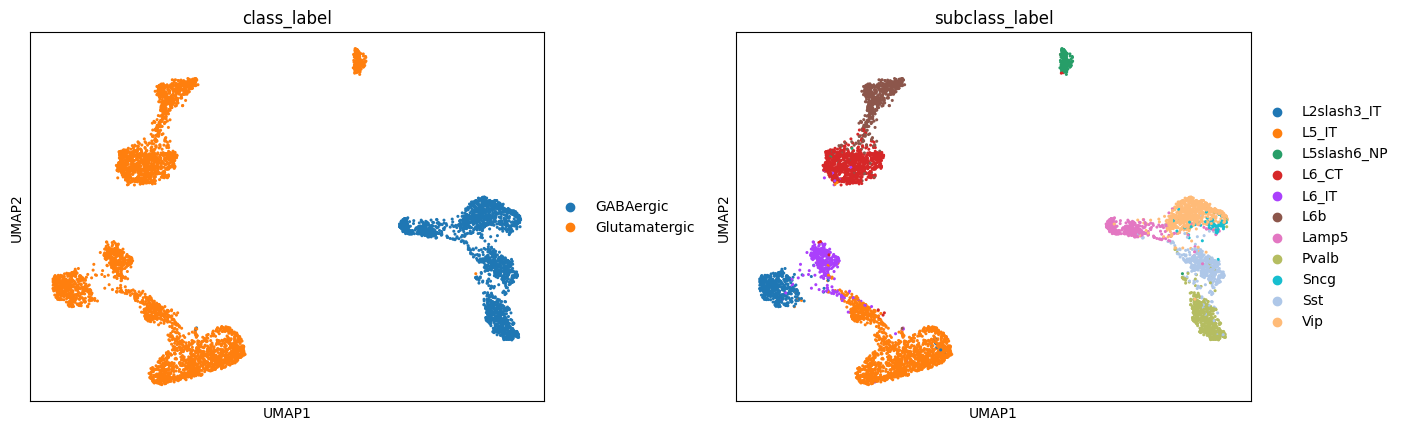

In [10]:
sc.pl.umap(adata, color=['class_label', 'subclass_label'], wspace=0.25)

In [11]:
adata.obs.subclass_label.value_counts()

L5_IT          1571
L6_CT           904
Vip             659
L6b             571
Pvalb           542
L2slash3_IT     483
Sst             427
L6_IT           395
Lamp5           376
L5slash6_NP     208
Sncg             84
Name: subclass_label, dtype: int64

In [12]:
groups_test = adata.obs.subclass_label.value_counts()[:9].index.tolist()
groups_test

['L5_IT',
 'L6_CT',
 'Vip',
 'L6b',
 'Pvalb',
 'L2slash3_IT',
 'Sst',
 'L6_IT',
 'Lamp5']

In [13]:
diff_spl_intron_groups, diff_spl_introns = run_differential_splicing_for_each_group(
    adata, "subclass_label", groups=groups_test, subset_to_groups=True,
    min_cells_per_intron_group=100, min_total_cells_per_intron=100,
    n_jobs=-1,  # -1 means use all cores
    # It will run much faster on a machine with multiple cores than in Colab
)

L5_IT
sample sizes:  1571 4357
(5928, 25729)
filter_min_cells_per_feature
filter_singletons
(5928, 25089)
filter_min_global_proportion
filter_singletons
(5928, 24670)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(5928, 23904)
Number of intron groups:  10398
Number of introns:  23904


100%|██████████| 10398/10398 [18:24<00:00,  9.41it/s]


L6_CT
sample sizes:  904 5024
(5928, 25729)
filter_min_cells_per_feature
filter_singletons
(5928, 25089)
filter_min_global_proportion
filter_singletons
(5928, 24670)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(5928, 21850)
Number of intron groups:  9418
Number of introns:  21850


100%|██████████| 9418/9418 [17:41<00:00,  8.87it/s]


Vip
sample sizes:  659 5269
(5928, 25729)
filter_min_cells_per_feature
filter_singletons
(5928, 25089)
filter_min_global_proportion
filter_singletons
(5928, 24670)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(5928, 16831)
Number of intron groups:  7137
Number of introns:  16831


100%|██████████| 7137/7137 [17:35<00:00,  6.76it/s]


L6b
sample sizes:  571 5357
(5928, 25729)
filter_min_cells_per_feature
filter_singletons
(5928, 25089)
filter_min_global_proportion
filter_singletons
(5928, 24670)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(5928, 20311)
Number of intron groups:  8717
Number of introns:  20311


100%|██████████| 8717/8717 [18:16<00:00,  7.95it/s]


Pvalb
sample sizes:  542 5386
(5928, 25729)
filter_min_cells_per_feature
filter_singletons
(5928, 25089)
filter_min_global_proportion
filter_singletons
(5928, 24670)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(5928, 16858)
Number of intron groups:  7175
Number of introns:  16858


100%|██████████| 7175/7175 [17:20<00:00,  6.90it/s]


L2slash3_IT
sample sizes:  483 5445
(5928, 25729)
filter_min_cells_per_feature
filter_singletons
(5928, 25089)
filter_min_global_proportion
filter_singletons
(5928, 24670)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(5928, 20804)
Number of intron groups:  8933
Number of introns:  20804


100%|██████████| 8933/8933 [18:23<00:00,  8.09it/s]


Sst
sample sizes:  427 5501
(5928, 25729)
filter_min_cells_per_feature
filter_singletons
(5928, 25089)
filter_min_global_proportion
filter_singletons
(5928, 24670)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(5928, 16588)
Number of intron groups:  7035
Number of introns:  16588


100%|██████████| 7035/7035 [17:03<00:00,  6.87it/s]


L6_IT
sample sizes:  395 5533
(5928, 25729)
filter_min_cells_per_feature
filter_singletons
(5928, 25089)
filter_min_global_proportion
filter_singletons
(5928, 24670)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(5928, 19541)
Number of intron groups:  8346
Number of introns:  19541


100%|██████████| 8346/8346 [17:58<00:00,  7.73it/s]


Lamp5
sample sizes:  376 5552
(5928, 25729)
filter_min_cells_per_feature
filter_singletons
(5928, 25089)
filter_min_global_proportion
filter_singletons
(5928, 24670)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(5928, 15780)
Number of intron groups:  6670
Number of introns:  15780


100%|██████████| 6670/6670 [16:56<00:00,  6.56it/s]


In [14]:
sig_diff_spl_intron_groups = diff_spl_intron_groups.query('p_value_adj < 0.05 and max_abs_delta_psi > 0.05')
sig_diff_spl_intron_groups.shape

(10485, 12)

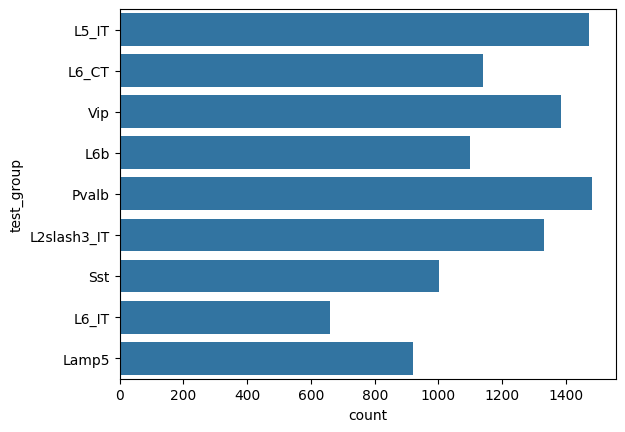

In [15]:
# Number of significant events per cell type
sns.countplot(sig_diff_spl_intron_groups, y="test_group", color="C0", order=groups_test);

In [16]:
# Calculate PSI (intron proportions) from intron counts
# This is expected to contain lots of nan's
adata.layers["PSI_raw"] = calculate_PSI(adata)

/usr/local/lib/python3.10/dist-packages/scquint/data.py:212: RuntimeWarning: invalid value encountered in true_divide
  return X / intron_group_sums[:,groups]


In [17]:
marker_introns = find_marker_introns(
    diff_spl_intron_groups, diff_spl_introns, n=10, min_delta_psi=0.3,
)
marker_introns = {c: marker_introns[c] for c in groups_test} # just reordering
marker_introns

{'L5_IT': ['Tiam1_chr16:89813128-89817960',
  'Rcan2_chr17:43836498-44017766',
  'Synpr_chr14:13454353-13493507',
  'Cntnap2_chr6:47193080-47271139',
  'Kalrn_chr16:34055116-34095795',
  'Sorbs1_chr19:40324833-40325470',
  'Mobp_chr9:120179167-120179326',
  'Zfp827_chr8:79141336-79175832',
  'Smg6_chr11:75132745-75139192',
  'Tac2_chr10:127728757-127729113'],
 'L6_CT': ['Grip1_chr10:119692622-119897714',
  'Aspg_chr12:112122124-112122943',
  'Osbp2_chr11:3726576-3819836',
  'Foxp1_chr6:99016666-99075853',
  'Plch2_chr4:154984966-154986214',
  'Enpp2_chr15:54919699-54952547',
  'Arnt2_chr7:84361669-84409854',
  'Mast4_chr13:102853920-103025521',
  'Adgrd1_chr5:129115178-129122410',
  'Fhit_chr14:10421614-10453368'],
 'Vip': ['Nrxn1_chr17:90597630-90623419',
  'Ptprd_chr4:76136922-76140513',
  'Nrxn3_chr12:89348450-89503017',
  'Fam131a_chr16:20694830-20695738',
  'Camk2a_chr18:60969044-60969993',
  'Caly_chr7:140081539-140082461',
  'Gas7_chr11:67455775-67603107',
  'Bcar3_chr3:12245509

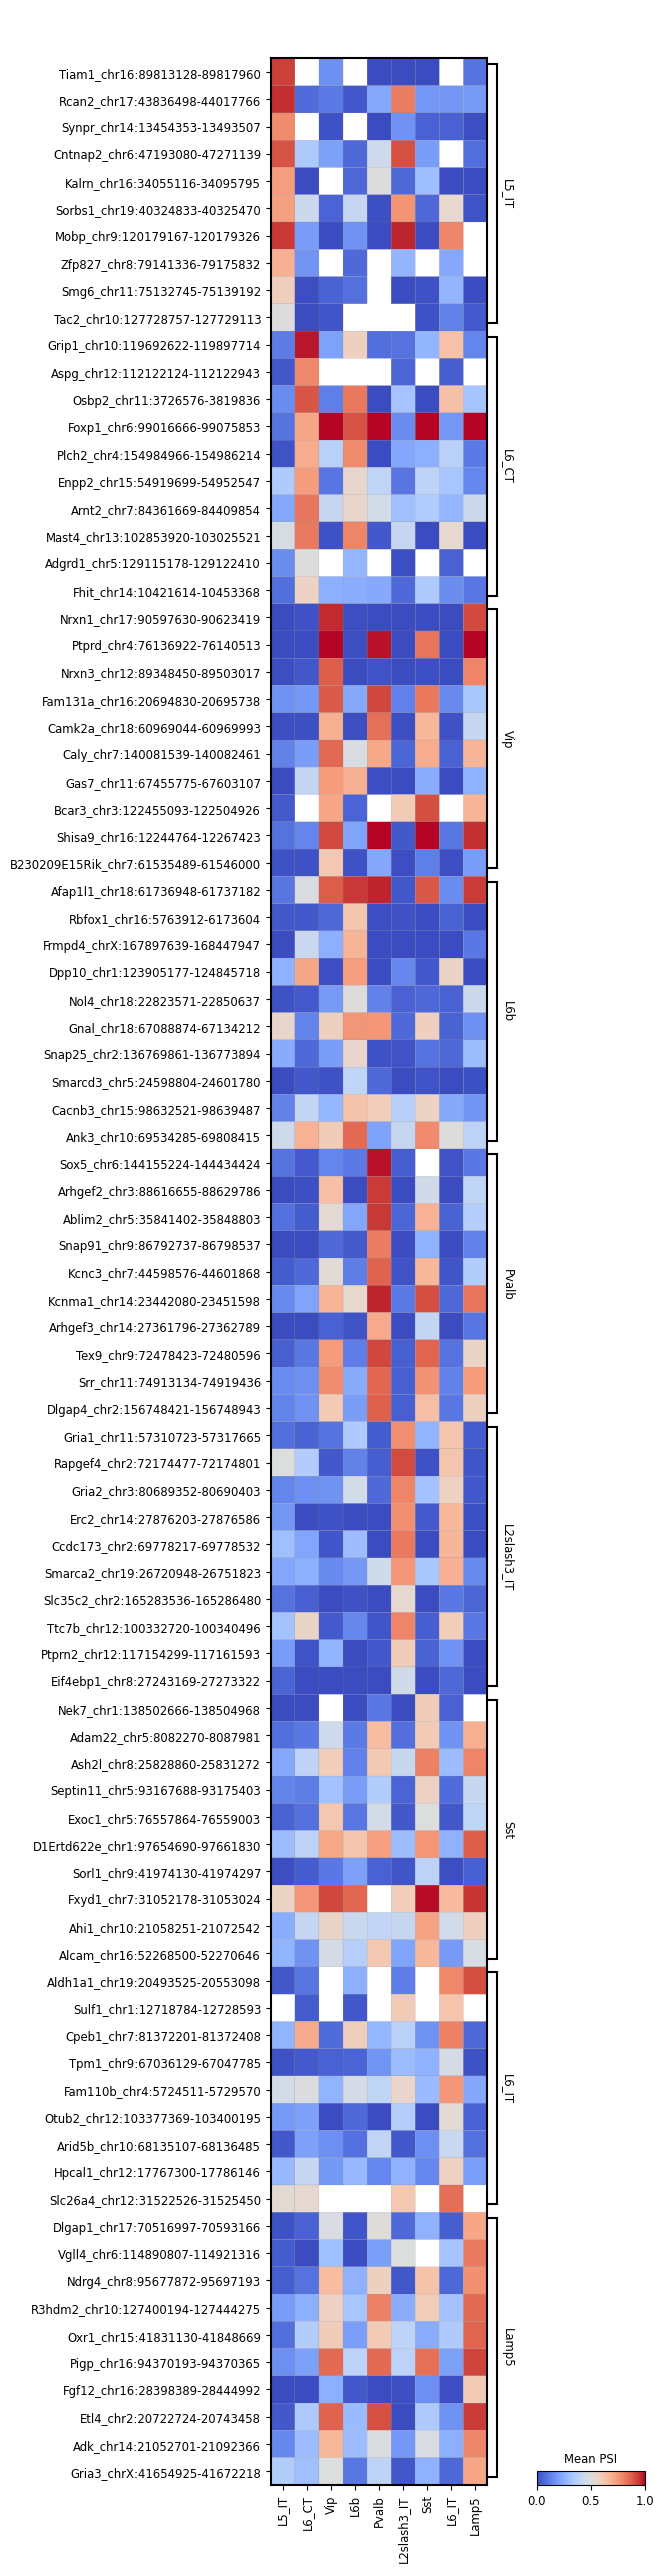

In [18]:
sc.pl.matrixplot(
    # we want to mask introns with less than min_cells=10 cells with defined PSI
    # to reduce noise in the heatmap visualization
    mask_PSI(
        adata[adata.obs.subclass_label.isin(groups_test)],
        marker_introns, "subclass_label", min_cells=10
    ),
    marker_introns, 'subclass_label', cmap='coolwarm', categories_order=groups_test,
    swap_axes=True, layer="PSI_raw_masked", colorbar_title="Mean PSI", vmin=0, vmax=1,
)

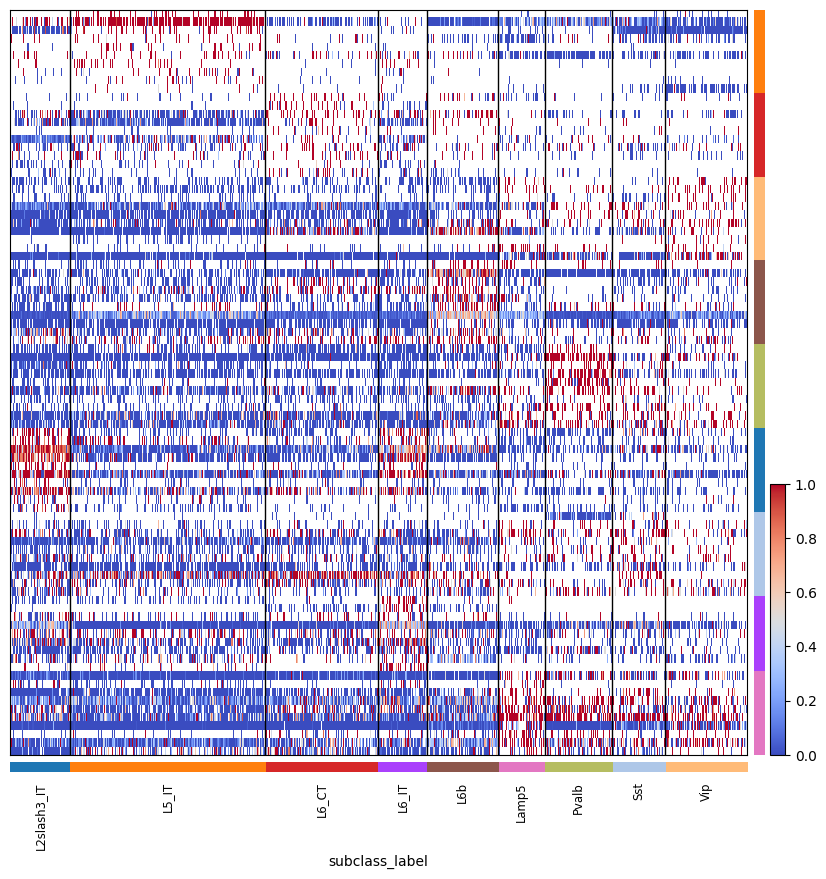

In [19]:
sc.pl.heatmap(
    mask_PSI(
        adata[adata.obs.subclass_label.isin(groups_test)],
        marker_introns, "subclass_label", min_cells=10
    ),
    marker_introns,
    'subclass_label',
    cmap='coolwarm',
    #categories_order=groups_test,  # not working for some reason
    swap_axes=True,
    layer="PSI_raw_masked",
    vmin=0,
    vmax=1,
    figsize=(10, 10),
)

In [20]:
# The results can be further visualized with
# the cellxgene browser https://scquint.ds.czbiohub.org/BICCN-mouse-primary-motor-cortex/
# and UCSC Genome Browser https://genome.ucsc.edu/s/gbenegas/primarymotorcortex